In [27]:
import requests
import math
import re
import os
import json
from os.path import exists
from tqdm import tqdm
from scipy.stats import entropy
from itertools import product
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options

#get path to project directory
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__"))
)

#file containing probabilities - important!
PATTERN_MATRIX_FILE = os.path.join(DATA_DIR, "pattern_matrix.csv")
WORD_FREQ_MAP_FILE = os.path.join(DATA_DIR, "freq_map.json")

#scrape wordle site for javasript source
url = 'https://www.nytimes.com/games/wordle/index.html'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
js_file = soup.find_all('script', {"src":True})[0]['src']
js_url = 'https://www.nytimes.com/games/wordle/' + js_file

#javascript soup
js_r = requests.get(js_url)
js_soup = BeautifulSoup(js_r.content, 'html.parser')

In [2]:
#regex to find word lists
js_str = str(js_soup)
pattern = r"(?<=Ma=\[)(.*)(?=\],Oa)"  #solutions
pattern2 = r"(?<=Oa=\[)(.*)(?=\],Ra)" #accepted guesses
answers_regex = re.findall(pattern, js_str)
guesses_regex = re.findall(pattern2, js_str)

In [3]:
#flatten & sort "answers" list
answers_2d = [word.replace('"','').split(',') for word in answers_regex]
answers = [item for sublist in answers_2d for item in sublist]
answers = [word.upper() for word in answers]
answers.sort()

#flatten & sort "guesses" list
guesses_2d = [word.replace('"','').split(',') for word in guesses_regex]
guesses = [item for sublist in guesses_2d for item in sublist]
guesses = [word.upper() for word in guesses]
guesses = guesses + answers
guesses.sort()

NUM_GUESSES = len(guesses)
NUM_ANSWERS = len(answers)

In [4]:
print(f'# of Answers: {NUM_ANSWERS}')
print(f'# of Possible Guesses: {NUM_GUESSES}')

# of Answers: 2309
# of Possible Guesses: 12947


In [5]:
answer_letter_counts = {}
guess_letter_counts = {}

for word in answers:
    for c in word:
        if c in answer_letter_counts:
            answer_letter_counts[c] += 1
        else:
            answer_letter_counts[c] = 1

for word in guesses:
    for c in word:
        if c in guess_letter_counts:
            guess_letter_counts[c] += 1
        else:
            guess_letter_counts[c] = 1

In [6]:
def addlabels(x,y):
    plt.text(x, y, y, ha = 'center', fontsize=10)

def plot_letter_dist(dic, title):
    #figure details
    fig, ax = plt.subplots(1,2,figsize=(20,8))
    fig.tight_layout()
    fig.suptitle(t=f'Distribution of {title}', va='bottom', fontsize=26)
        
    #plot1
    for i in sorted(dic.items()):
        ax[0].bar(i[0], dic[i[0]])
        # addlabels(i[0], i[1])

    #plot2
    for i in sorted(dic.items(), key = lambda x: x[1], reverse = True):
        ax[1].bar(i[0], i[1])
        # addlabels(i[0], i[1])
    
    #styling
    ax[0].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    ax[1].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    plt.show()

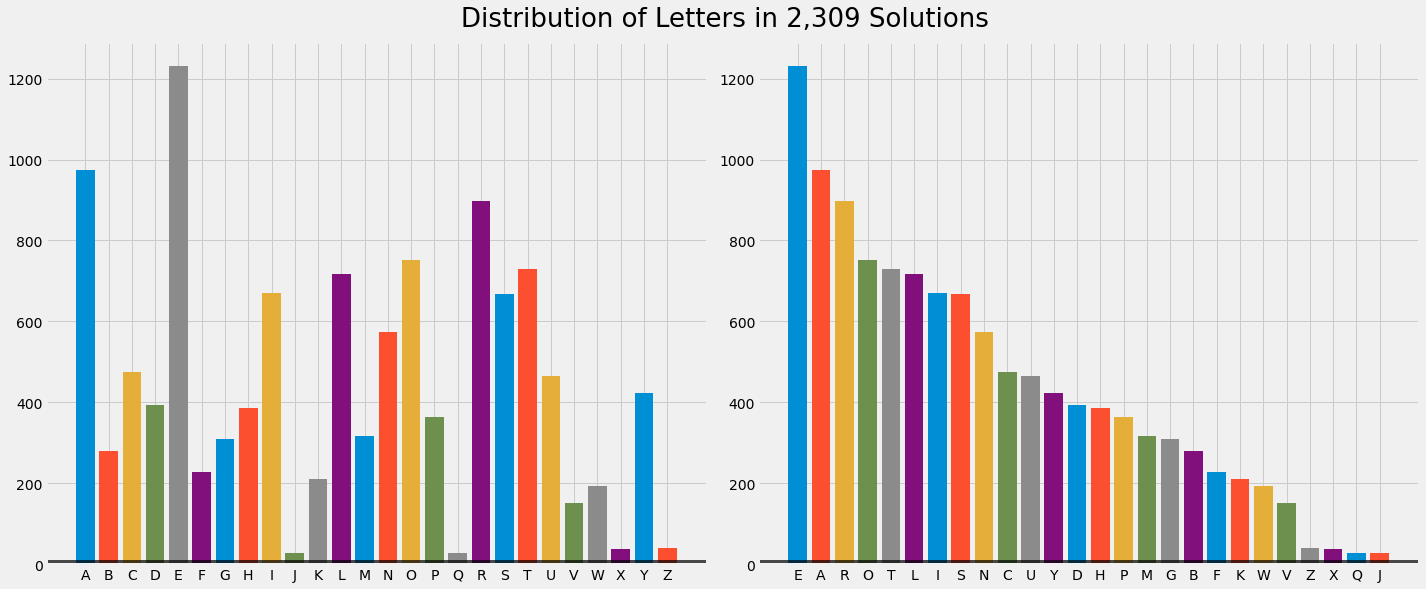

In [7]:
plot_letter_dist(answer_letter_counts, 'Letters in 2,309 Solutions')

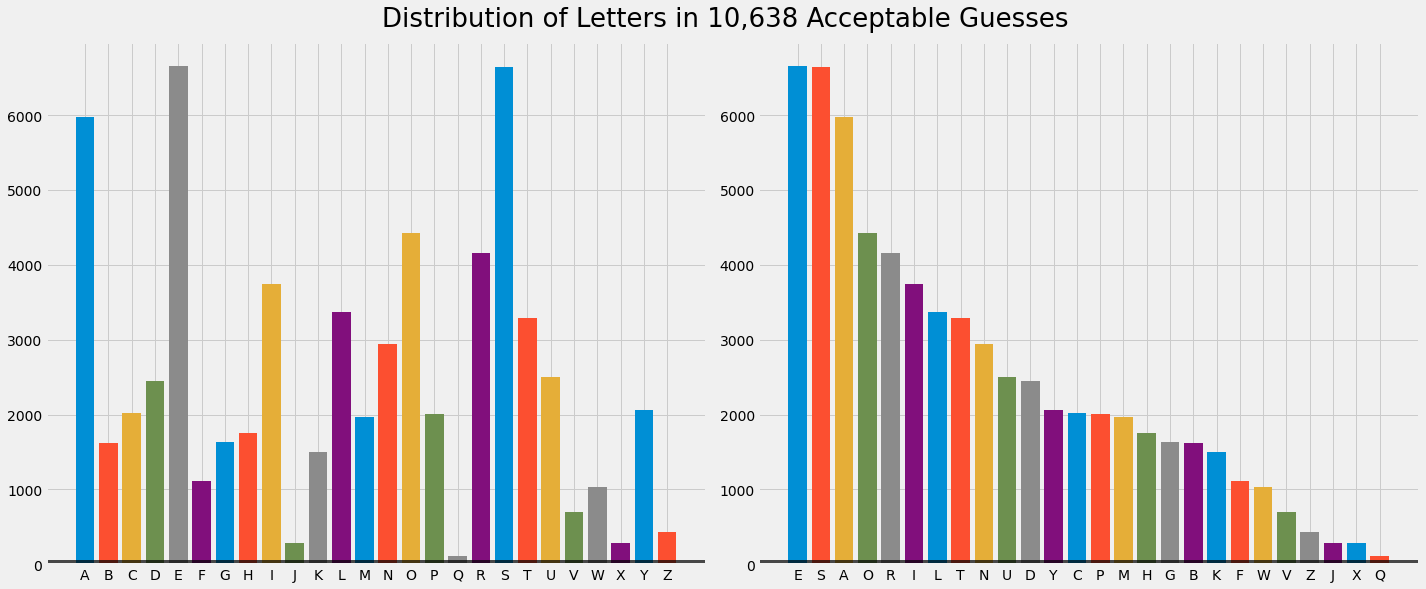

In [8]:
plot_letter_dist(guess_letter_counts, 'Letters in 10,638 Acceptable Guesses')

In [9]:
letter_list = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
               'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

def freq_count(data, pos):
    freq = {}
    
    #initialize every value to 0
    for letter in letter_list:
        freq[letter] = 0
    
    #calculate frequency table
    for word in data:
        word = word.upper()
        if word[pos] in freq:
            freq[word[pos]] += 1
        else:
            freq[word[pos]] = 1

    return freq

In [10]:
#calculates letter frequency for answers
letter1_answer_counts = freq_count(answers, 0)
letter2_answer_counts = freq_count(answers, 1)
letter3_answer_counts = freq_count(answers, 2)
letter4_answer_counts = freq_count(answers, 3)
letter5_answer_counts = freq_count(answers, 4)

#calculates letter frequency for guesses
letter1_guess_counts = freq_count(guesses, 0)
letter2_guess_counts = freq_count(guesses, 1)
letter3_guess_counts = freq_count(guesses, 2)
letter4_guess_counts = freq_count(guesses, 3)
letter5_guess_counts = freq_count(guesses, 4)

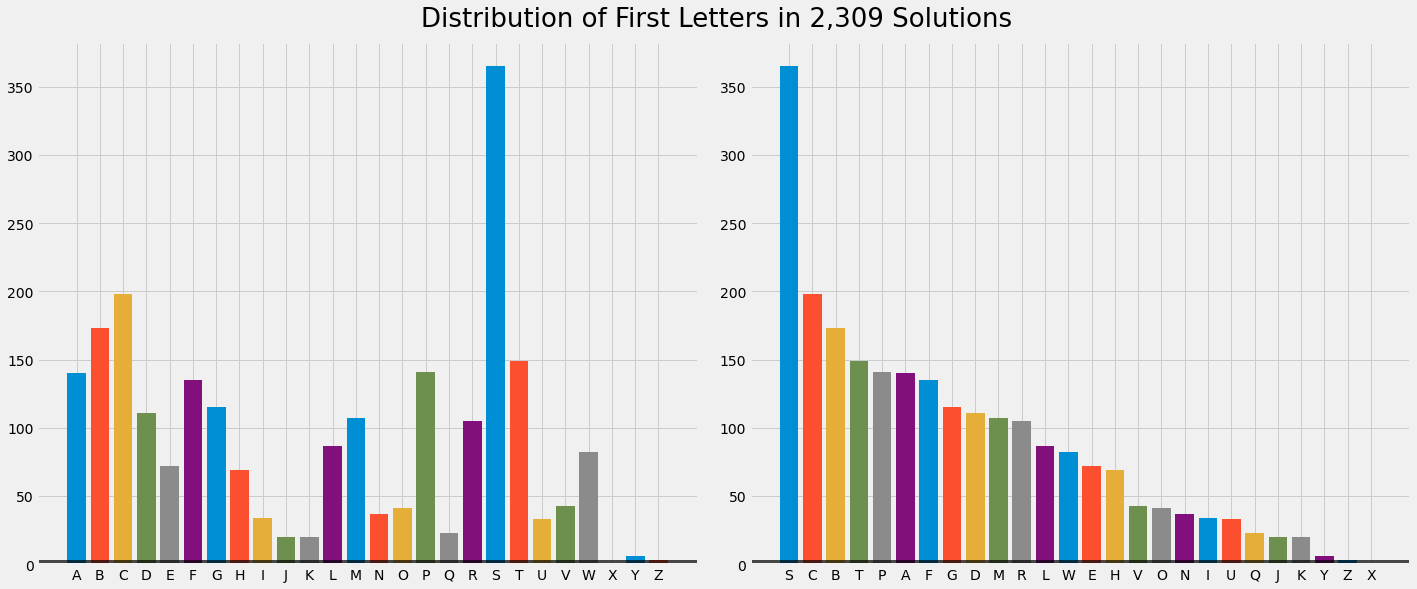

In [11]:
plot_letter_dist(letter1_answer_counts, 'First Letters in 2,309 Solutions')

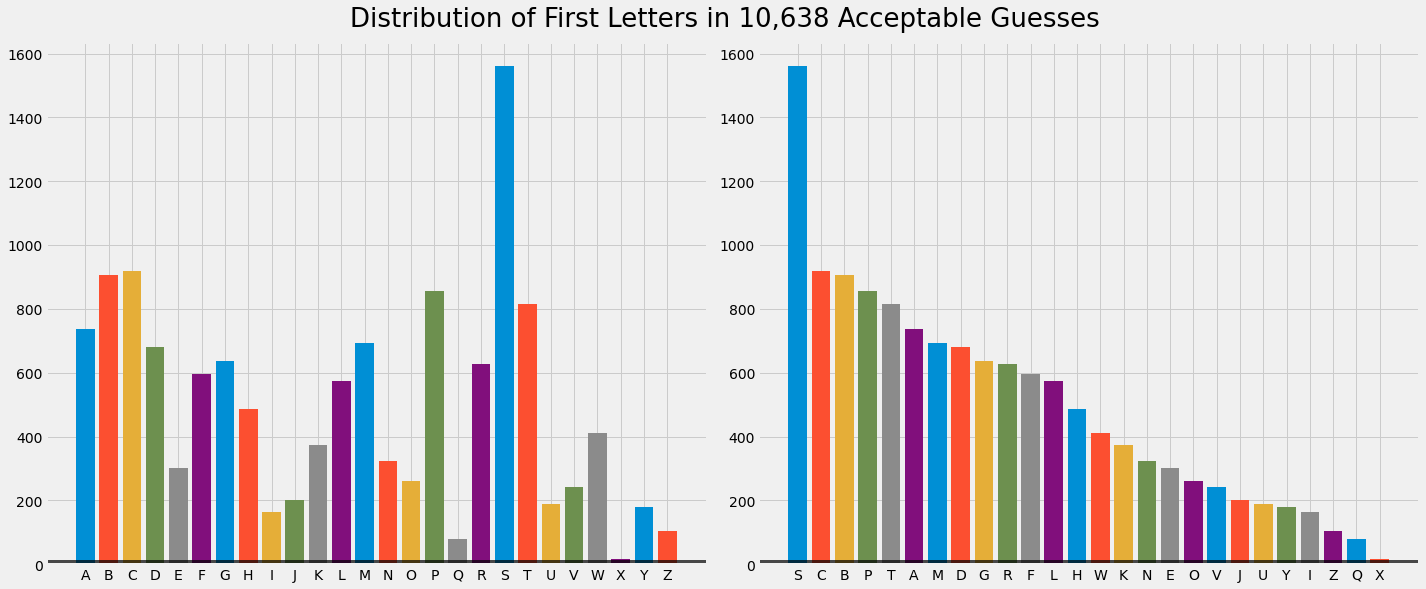

In [12]:
plot_letter_dist(letter1_guess_counts, 'First Letters in 10,638 Acceptable Guesses')

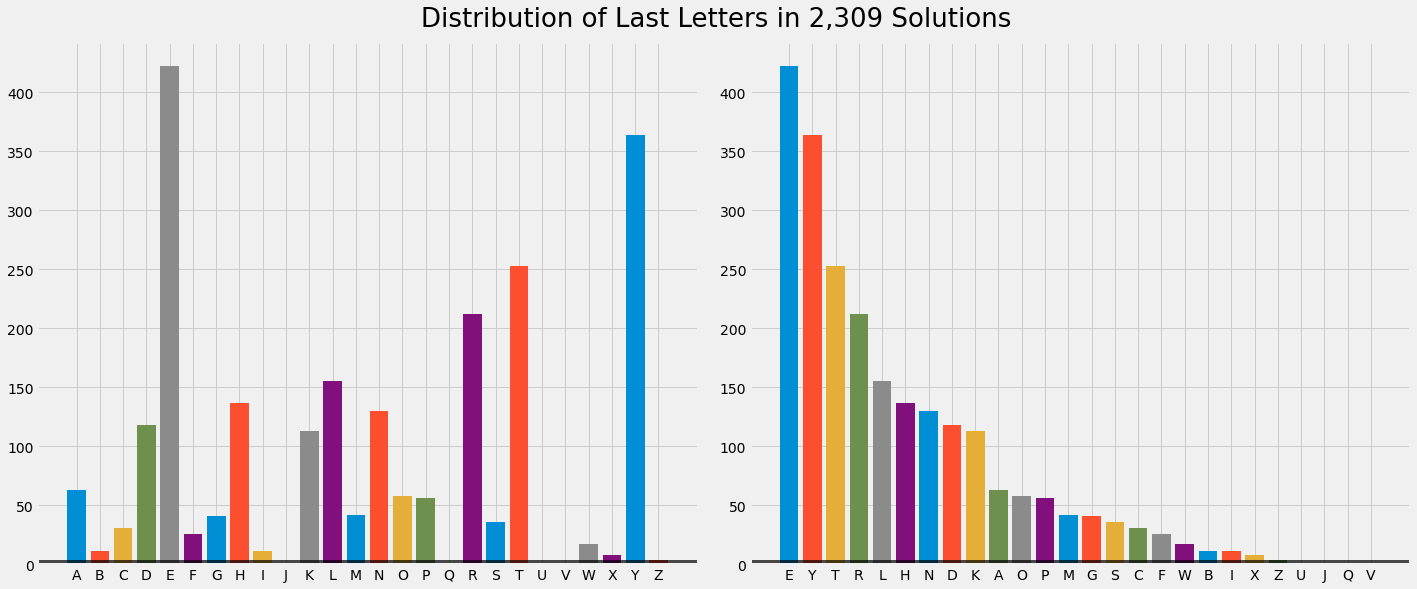

In [13]:
plot_letter_dist(letter5_answer_counts, 'Last Letters in 2,309 Solutions')

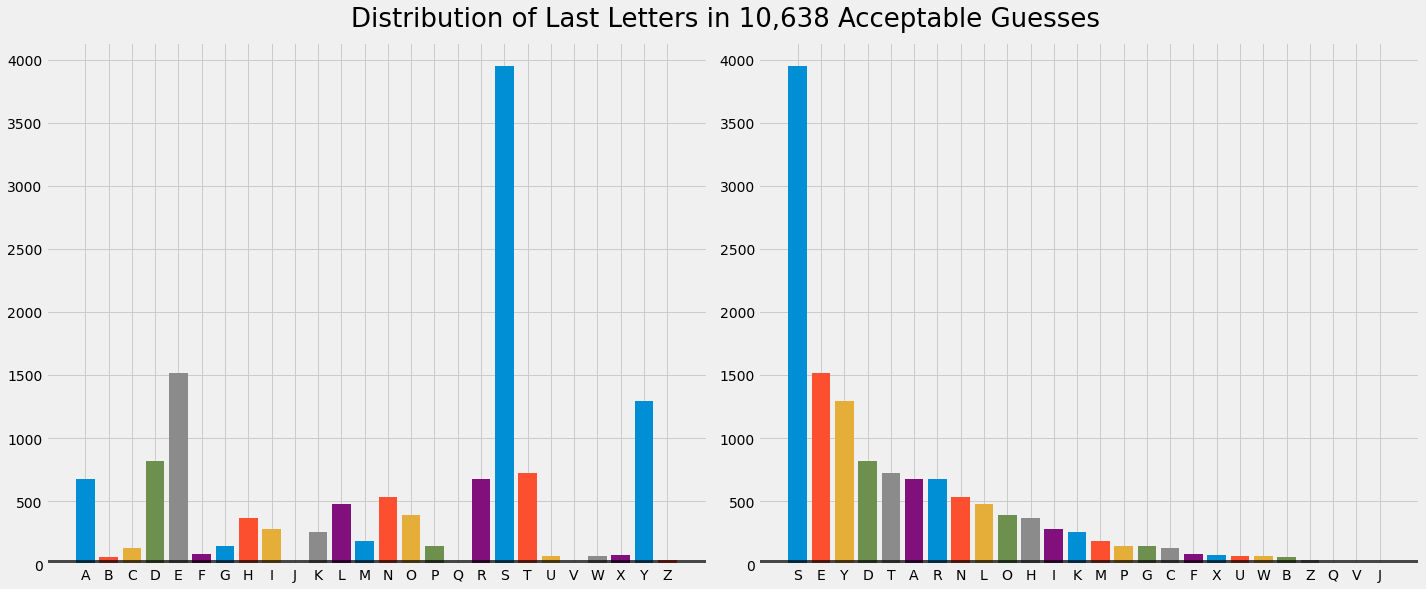

In [14]:
plot_letter_dist(letter5_guess_counts, 'Last Letters in 10,638 Acceptable Guesses')

In [15]:
#calculate probability for each letter in each position
def letter_prob_guesses(letter):
    letter = letter.upper()
    letter1 = letter1_guess_counts[letter] / NUM_GUESSES
    letter2 = letter2_guess_counts[letter] / NUM_GUESSES
    letter3 = letter3_guess_counts[letter] / NUM_GUESSES
    letter4 = letter4_guess_counts[letter] / NUM_GUESSES
    letter5 = letter5_guess_counts[letter] / NUM_GUESSES
    
    return [letter1, letter2, letter3, letter4, letter5]

In [16]:
#create df of probabilities for each letter in each position
letters = pd.DataFrame(columns = ['1st', '2nd', '3rd', '4th', '5th'],
                       index=sorted(guess_letter_counts.keys()))

for i in range(26):
    probs = letter_prob_guesses(letter_list[i])
    for j in range(5):
        letters.iloc[i,j] = probs[j]
        
letters

,1st,2nd,3rd,4th,5th
A,0.056847,0.174558,0.095389,0.082876,0.052445
B,0.070132,0.006256,0.025797,0.018692,0.004557
C,0.071059,0.013594,0.030277,0.031359,0.009809
D,0.052599,0.006488,0.030123,0.036379,0.06349
E,0.023403,0.125589,0.068124,0.179424,0.117324
F,0.045957,0.001854,0.013748,0.017996,0.006334
G,0.049201,0.005793,0.02796,0.032594,0.011045
H,0.037692,0.042017,0.009269,0.018151,0.028346
I,0.012744,0.106588,0.080868,0.067969,0.021627
J,0.015602,0.00085,0.003553,0.00224,0.000232


In [103]:
#12,972 / 2,315 - old list numbers
#12,947 / 2,309 - current list numbers

#243 combinations of colors (3^5) - g = green, r = gray, y = yellow
combinations = [''.join(i) for i in product('gry', repeat = 5)]

#return list of guess words that have given letter in given position
def choices_inc(letter, pos, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if word[pos-1] == letter:
            choices.append(word)
            
    return choices

#return list of guess words that contain letter NOT in given position
def choices_exc(letter, pos=0, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
    
    for word in word_bank:            
        if word[pos-1] != letter and letter in word:
            choices.append(word)
   
    return choices

#return list of guess words that do NOT contain letter at all
def choices_abs_exc (letter, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if letter not in word:
            choices.append(word)
    
    return choices

#calculates probability of given word and results
def get_probability(word, colors):
    word = word.upper()
    
    #list to contain lists of remaining possible matches
    pool = []
    
    #loop over each letter / color pair and compute remaining matches
    for i in range(5):
        #letter 1
        if i == 0:            
            if colors[i] == 'g': #green
                rem_set = choices_inc(word[i], i+1)
            elif colors[i] == 'r': #gray
                rem_set = choices_abs_exc(word[i])
            else: #yellow
                rem_set = choices_exc(word[i], i+1)
        
        #letters 2-5
        else:            
            if colors[i] == 'g':
                rem_set = choices_inc(word[i], i+1, pool[-1])
            elif colors[i] == 'r':
                rem_set = choices_abs_exc(word[i], pool[-1])
            else:
                rem_set = choices_exc(word[i], i+1, pool[-1])
        
        #adds remaining possible matches to pool
        if rem_set or len(rem_set) == 0:            
            pool.append(rem_set)

        # print(f'{word[i].upper()}, {colors[i]}, {len(rem_set)} matches left')
        
    num_matches = len(pool[-1])
    probability = num_matches / NUM_GUESSES
    
    #print possible matches
    if pool[-1] == []:
        pool[-1] = [0]
        
    return probability, pool[-1]

#calculate information gain
def get_information(prob):
    if prob == 0:
        return 0.00
    return math.log2(1/prob)

#calculate entrooy - NOT WORKING YET
def get_entropy(data):    
    distributions = pd.Series(data)
    axis = len(distributions.shape) - 1
    return entropy(distributions, base=2.0, axis=axis)

#if PATTERN_MATRIX_FILE doesn't exist, create it - takes 45+ minutes!
def get_pattern_matrix(words, combos):
    if not os.path.exists(PATTERN_MATRIX_FILE):
        all_p = {}
        for word in tqdm(words):
            all_p[word] = [get_probability(word, combo)[0] for combo in combos]

        #create dataframe of all probabilities
        pattern_matrix = pd.DataFrame.from_dict(all_p, orient='index', columns=combos).set_index('index')

        #create .csv file so we don't have to re-compute every time
        pattern_matrix.to_csv(f'pattern_matrix.csv', index=True)
        return pattern_matrix
    
    #if PATTERN_MATRIX_FILE exists, read it in to df and return
    else:
        pattern_matrix = pd.read_csv('pattern_matrix.csv', index_col='index')
        return pattern_matrix

def plot_pattern_distr(word):
    #create temp df
    df = pd.DataFrame(columns = ['Probability'])

    #assigns probability 
    df['Probability'] = patterns.loc[word]

    #sorts highest -> lowest probability
    df.sort_values(by='Probability', ascending=False, inplace=True)
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Probability Distribution - [{word}]', fontsize=22)
    fig.tight_layout()

    #plot
    sns.barplot(x=df.index, y=df['Probability'], palette='crest')
   
    #annotations
    xloc1 = 0
    yloc1 = df.iloc[xloc1,0]
    
    #higher entropy for most common
    ax.annotate(f'Max Entropy = {round(get_entropy(patterns.loc[word]),2)}', fontsize=16,
                xy=(xloc1, yloc1), xytext=(xloc1+15, yloc1), 
                arrowprops=dict(arrowstyle='simple', facecolor='black'))
    
    #TODO - FIGURE OUT SECOND ANNOTATION - VERY INVOLVED!
#     xloc2 = 120
#     yloc2 = df.iloc[xloc2,0]
#     print(f'xloc: {xloc2}, yloc: {yloc2}')
#     print(f'df.iloc[xloc2, 0] = {df.iloc[xloc2, 0]}')
    
    
    
#     ind_calc = df[df['Probability'] == yloc2].index[0]
#     ind_p = get_probability(word, ind_calc)[0]
#     ind_i = get_information(ind_p)
    
    
#     #lower entropy for least common
#     ax.annotate(f'Entropy = {round(get_entropy(yloc2),2)}', fontsize=16,
#                 xy=(xloc2, yloc2), xytext=(xloc2-25, yloc2+0.01), 
#                 arrowprops=dict(arrowstyle='simple', facecolor='black'))

    #plot details    
    # ax.grid(visible=False)
    # ax.set_yscale('log')
    ax.set_xlim(-2,125,1)
    ax.set_xlabel(f'Patterns', fontsize=16)
    ax.set(ylabel=None)
    # ax.set_ylabel('Probability', fontsize=16)
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelsize=12)
    ax.axhline(y = -0.00025, color = 'black', linewidth = 3, alpha = .7)
    plt.show()

    #removes bad words from freq_map (NYT made these changes)
def get_word_frequencies(regenerate=False):
    bad_words = ['bitch', 'chink', 'coons', 'darky', 'dyked', 'dykes', 'dykey',
                 'faggy', 'fagot', 'gooks', 'homos', 'kikes', 'lesbo', 'pussy',
                 'sluts', 'spick', 'spics', 'spiks', 'whore', 'agora', 'fibre',
                 'lynch', 'pupal', 'slave', 'wench']
    if os.path.exists(WORD_FREQ_MAP_FILE) or regenerate:
        with open(WORD_FREQ_MAP_FILE) as fp:
            result = json.load(fp)
            for word in bad_words:
                del result[word]
        return result

#implementation of a sigmoid function
def sigmoid(x):  
    z = np.exp(-x)
    sig = 1 / (1 + z)
    return sig

#gets most commonly used words based on frequency
def get_freq_based_priority(n_common=3000, width_under_sigmoid=10):
    #get frequency map
    freq_map = get_word_frequencies()
    freqs_l = np.array([w for w in freq_map.keys()])
    freqs = np.array([freq_map[w] for w in freqs_l])

    #sorts list of frequencies - but returns indexes!
    arg_sort = freqs.argsort()

    #actually sorts list, converts to list() and capitalizes each word
    sorted_words = freqs_l[arg_sort].tolist()
    sorted_words = [w.upper() for w in sorted_words]

    #"bin" width for each word
    c = width_under_sigmoid * (-0.5 + n_common / NUM_GUESSES)
    xs = np.linspace(c - x_width / 2, c + x_width / 2, NUM_GUESSES)
    
    #dict to hold words
    priorities = dict()
    
    for word, x in zip(sorted_words, xs):
        priorities[word] = sigmoid(x)
    return priorities

In [18]:
#returns dataframe of ALL probabilities for EVERY combination of EVERY word
patterns = get_pattern_matrix(guesses, combinations)
patterns.head()

,ggggg,ggggr,ggggy,gggrg,gggrr,gggry,gggyg,gggyr,gggyy,ggrgg,...,yyryy,yyygg,yyygr,yyygy,yyyrg,yyyrr,yyyry,yyyyg,yyyyr,yyyyy
index,,,,,,,,,,,,,,,,,,,,,
AAHED,0.000077,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.005870,0.000077,0.000154,0.000000,0.000386,0.016606,0.001313,0.000232,0.005407,0.000463
AALII,0.000077,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.015525,0.000000,0.000000,0.001931,0.000000,0.034989,0.000000,0.000463,0.000000,0.005098
AARGH,0.000077,0.0,0.000000,0.000000,0.000077,0.000000,0.0,0.0,0.0,0.0,...,0.000927,0.000000,0.000463,0.000000,0.000618,0.039005,0.003167,0.000077,0.005252,0.000000
AARTI,0.000077,0.0,0.000000,0.000000,0.000077,0.000000,0.0,0.0,0.0,0.0,...,0.003630,0.000077,0.001699,0.000154,0.000541,0.031745,0.005561,0.000077,0.007415,0.001313
ABACA,0.000077,0.0,0.000232,0.000154,0.000000,0.000541,0.0,0.0,0.0,0.0,...,0.000000,0.000232,0.000000,0.000386,0.005407,0.000000,0.023480,0.000463,0.000000,0.001854


Probability of [SLATE] w/ [grryg] pattern = 0.0015
Information Gained in Bits = 9.41
Max Entropy - [SLATE] = 5.872430217496487


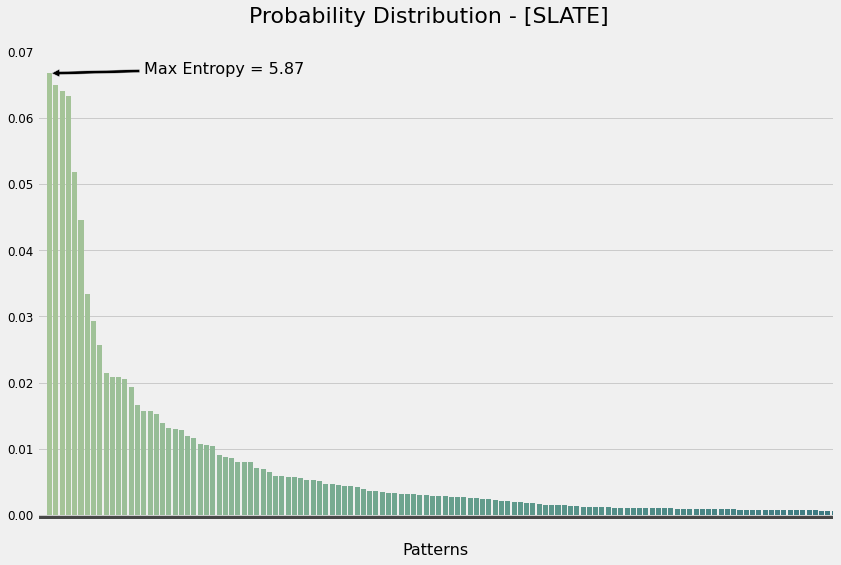

In [107]:
#testing functionality
find_word = 'SLATE'
find_patt = 'grryg'

#finds probability of given word with given pattern
p = patterns.loc[find_word, find_patt]
print(f'Probability of [{find_word}] w/ [{find_patt}] pattern = {round(p,4)}')

#calculates information gain in bits
i = get_information(p)
print(f"Information Gained in Bits = {round(i,2)}")

# #print # of matches
# print(f'{len(matches)} possible matches')

#calculate entropy
print(f'Max Entropy - [{find_word}] = {get_entropy(patterns.loc[find_word])}')

#plot probability distribution
plot_pattern_distr(find_word)

In [108]:
priorities = get_freq_based_priority()